# SCVI for cell class prediction and data projection

This notebook provides examples to utilize the pretrained SCVI model with user data. For more information on the model please refer to the Census Model page (TODO insert link).

**Contents**

1. Requirements.
1. Preparing data and model.
1. Using the SCVI pretrained model for **data projection**.
1. Using the SCVI pretrained model for **cell class inference**.


⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Requirements

### System requirements

To run this notebook the following are required:

- Unix system.
- A system with one or more GPUs is highly recommended.
- [AWS command-line interface](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html).
- [scvi-tools](https://github.com/scverse/scvi-tools) and its dependencies.
- CELLxGENE Census package

### Example data and fine-tuned model

Throughout the notebook the 10X PBMC 3K dataset will be used, you can download it via the following shell commands.


In [1]:
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2023-12-12 21:14:59 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


We will also need the pretrained SCVI model:

In [1]:
!aws s3 sync s3://pablo-tmp-west-coast-2/scvi-human-4-2023-10-23/scvi.model scvi-10-23-2023/scvi.model

folder = "scvi-10-23-2023"

## Using the SCVI pretrained model for **data projection**
Import all the required packages for this demonstration

In [2]:
import functools
import gc
import scanpy as sc
import os
import cellxgene_census
import numpy as np
import pandas as pd
import scvi
import tiledbsoma as soma
import yaml
from sklearn.ensemble import RandomForestClassifier
import warnings

/home/ssm-user/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Load the example query dataset (the 10X pbmc3k data).

In [3]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] =  adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
# initialize the batch to be unassigned. This could be any dummy value.
adata.obs["batch"] = "unassigned"

Load the SCVI model and prepare the query data

In [9]:
model_filename = f"{folder}/scvi.model"
scvi.model.SCVI.prepare_query_anndata(adata, model_filename)

INFO     File scvi-10-23-2023/scvi.model/model.pt already downloaded                                               
INFO     Found 62.2% reference vars in query data.                                                                 


/tmp/ipykernel_24058/1252447087.py:2: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  scvi.model.SCVI.prepare_query_anndata(adata, model_filename)


Load the query data into the model, set "is_trained" to True to trick the model into thinking it was already trained, and do a forward pass through the model to get the latent reprsentation of the query data.

In [10]:
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    model_filename,
)
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

# filter out missing features
adata = adata[:,adata.var['gene_symbols'].notnull().values].copy()
adata.var.set_index('gene_symbols',inplace=True)

INFO     File scvi-10-23-2023/scvi.model/model.pt already downloaded                                               


<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Run UMAP

In [11]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)

Run leiden clustering

In [12]:
sc.tl.leiden(adata)

Normalize and log-transform the expression data

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Using the marker genes from the [Scanpy pbmc3k vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html), we can map our leiden clusters to the corresponding cell type labels used in the tutorial. Our Leiden clustering does not match up perfectly so we need to visualize the marker genes to appropriately map the clusters to the original cell type annotation.
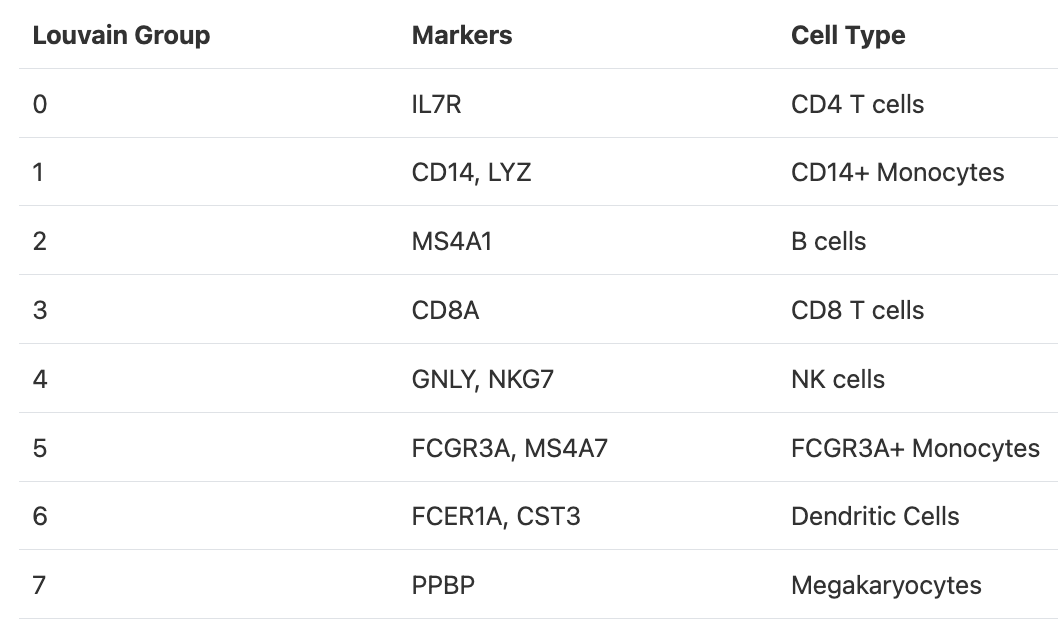

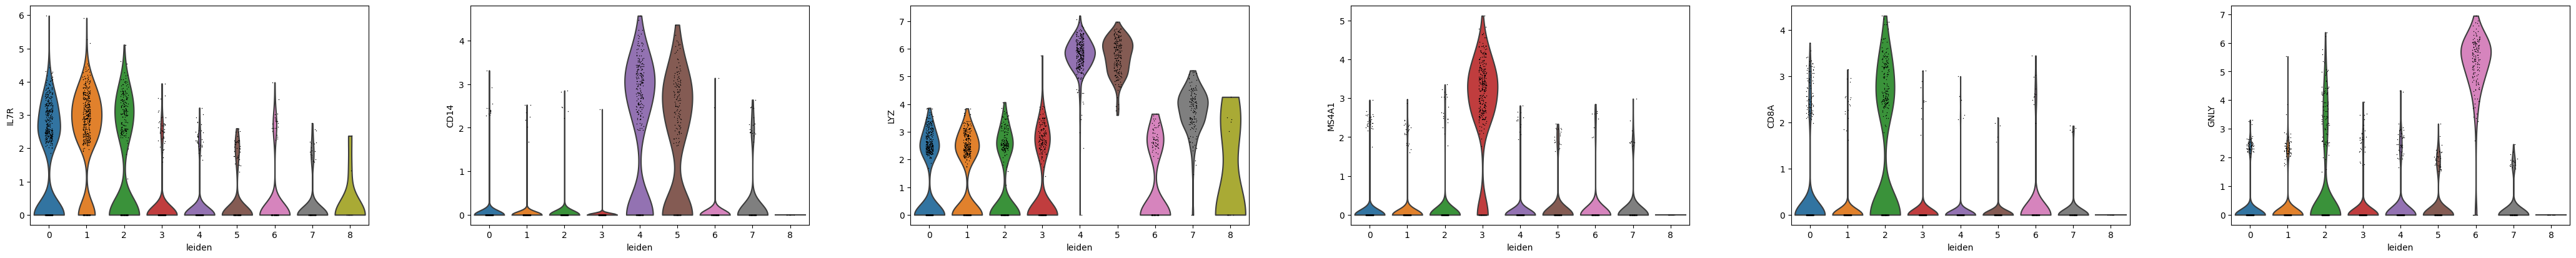

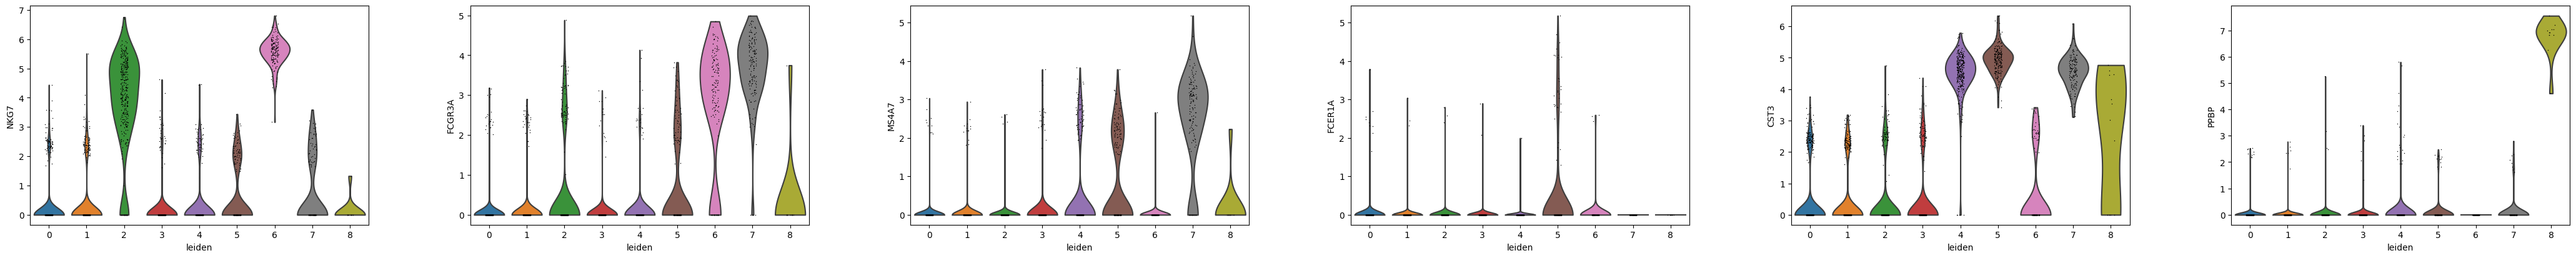

In [14]:
markers1 = ["IL7R", "CD14", "LYZ", "MS4A1", "CD8A", "GNLY"] 
markers2 = ["NKG7", "FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"]

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    sc.pl.violin(adata, markers1, groupby='leiden')
    sc.pl.violin(adata, markers2, groupby='leiden')

Based on the expression of the provided marker genes, we can make the following Leiden clusters to these cell type labels:

 - 0,1 = CD4 T cells
 - 4,5 = CD14+ monocytes
 - 3 = B cells
 - 2 = CD8 T cells
 - 6 = NK cells
 - 7 = FCGR3A+ Monocytes
 - 5 = dendritic cells
 - 8 = megakaryocytes

In [15]:
original_cell_types = [
    "CD4 T cells",
    "CD4 T cells",
    "CD8 T cells",    
    "B cells",
    "CD14+ monocytes",
    "dendritic cells",
    "NK cells",
    "FCGR3A+ Monocytes",
    "megakaryocytes",
]
label_mapping = dict(zip(range(len(original_cell_types)),original_cell_types))
adata.obs['original_cell_type'] = adata.obs['leiden'].apply(lambda x: label_mapping[int(x)])


Display the scatter plot

/home/ssm-user/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ssm-user/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


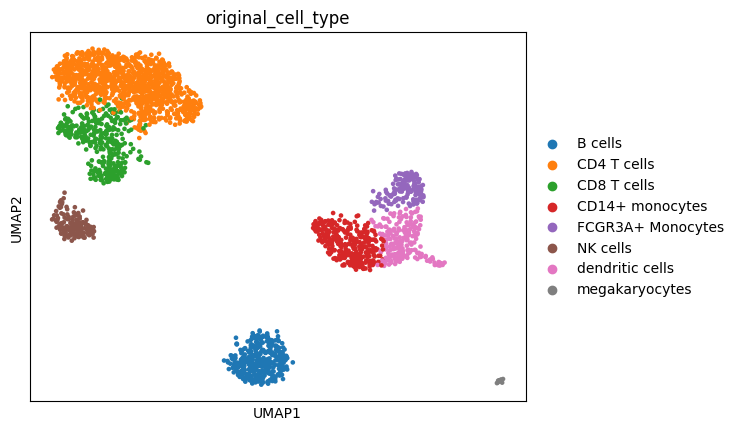

In [16]:
sc.pl.umap(adata, color=["original_cell_type"])

## Using the SCVI pretrained model for **cell class inference**.

Fetch the reference SCVI embeddings corresponding to some example PBMC data from Census

In [17]:
soma_context = soma.options.SOMATileDBContext(
        tiledb_config={
            "soma.init_buffer_bytes": 4 * 1024**3,
            "py.init_buffer_bytes": 4 * 1024**3,
            "vfs.s3.region": "us-west-2",
        }
    )

census = cellxgene_census.open_soma(uri="s3://bruce-tmp/emb-build-2023-12-10/2023-10-23/soma/", context=soma_context)

# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e
dataset_ids=["fa8605cf-f27e-44af-ac2a-476bee4410d3", "3c75a463-6a87-4132-83a8-c3002624394d"]

adata_census = cellxgene_census.get_anndata(
    census=census,
    measurement_name="RNA",
    organism="Homo sapiens",
    obs_value_filter=f"dataset_id in {dataset_ids}",
    obsm_layers = ["scvi"],
)
adata_census.var.set_index("feature_id",inplace=True)

Fit a Random Forest Classifier on the reference SCVI embedding fetched from Census and use it to predict cell type labels on the projected SCVI embedding for the query dataset.

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(adata_census.obsm['scvi'],adata_census.obs['cell_type'].values)
adata.obs['predicted_cell_type'] = rfc.predict(adata.obsm['scvi'])

Plot the results and compare the annotations

/home/ssm-user/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ssm-user/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ssm-user/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ssm-user/.local/

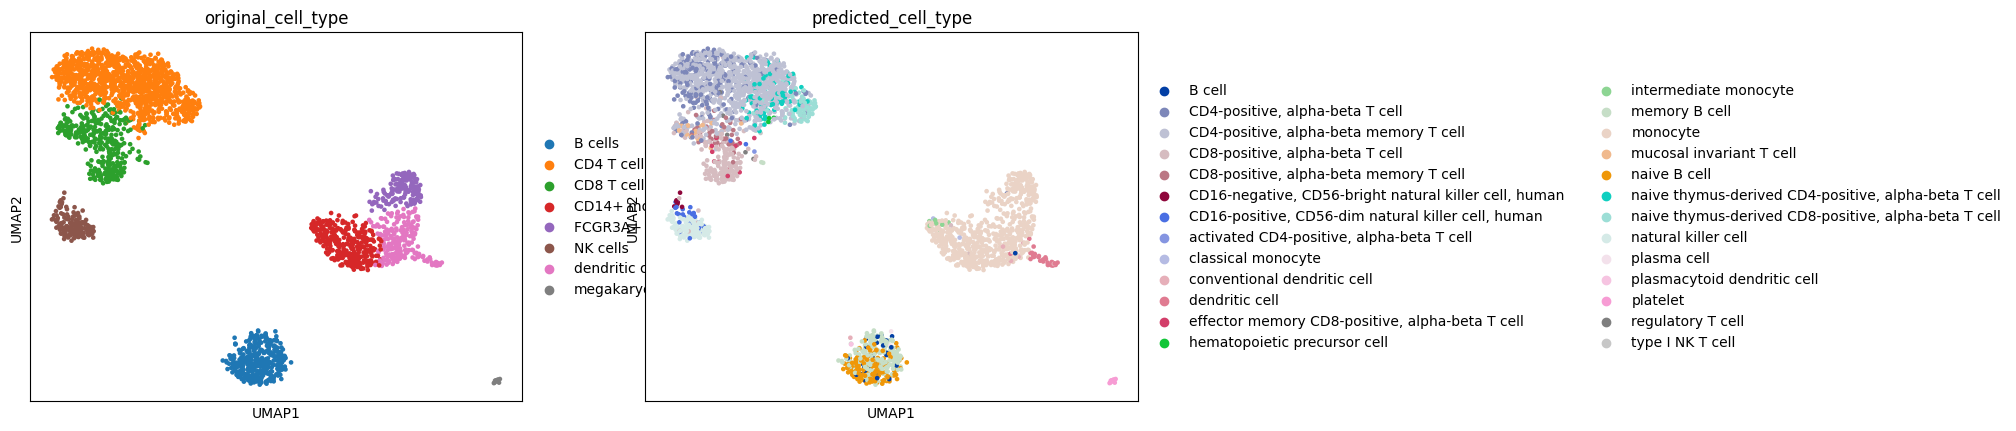

In [20]:
sc.pl.umap(adata, color=['original_cell_type', 'predicted_cell_type'])